# Exploratory Data Analysis for used BMW car sales in the UK

In this notebook we will explore the dataset to perform various types of analysis. 

In [1]:
# Library imports
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Disabling warnings:
import warnings
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')

In [2]:
# Read the data from local 
df = pd.read_csv("bmw.csv")

## Bassic informattion about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


In [4]:
# Lets look at first few records 
df.head().T

,0,1,2,3,4
model,5 Series,6 Series,5 Series,1 Series,7 Series
year,2014,2018,2016,2017,2014
price,11200,27000,16000,12750,14500
transmission,Automatic,Automatic,Automatic,Automatic,Automatic
mileage,67068,14827,62794,26676,39554
fuelType,Diesel,Petrol,Diesel,Diesel,Diesel
tax,125,145,160,145,160
mpg,57.6,42.8,51.4,72.4,50.4
engineSize,2.0,2.0,3.0,1.5,3.0


In [5]:
#checking unique values in different variables

unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).T

,unique value count
model,24
year,25
price,3777
transmission,3
mileage,8086
fuelType,5
tax,38
mpg,102
engineSize,17


 ## Check for missing values

In [6]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

<Axes: >

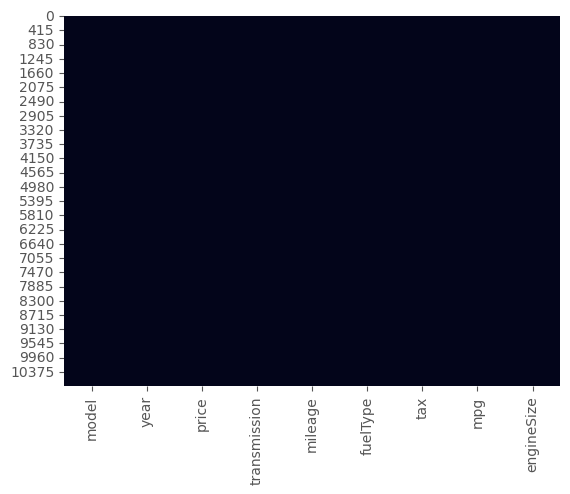

In [7]:
# Using example from https://seaborn.pydata.org/tutorial/color_palettes.html#,cmap='viridis'
sns.color_palette("Paired")
sns.heatmap(df.isnull(),cbar=False)

It can bee seen from above that there are no missing values in out dataset. Hooray!

## Check for duplicated records

In [8]:
print("We have {0} duplicated records in the dataset".format(df.duplicated(subset=df.columns.tolist(), keep='first').sum()))

We have 117 duplicated records in the dataset


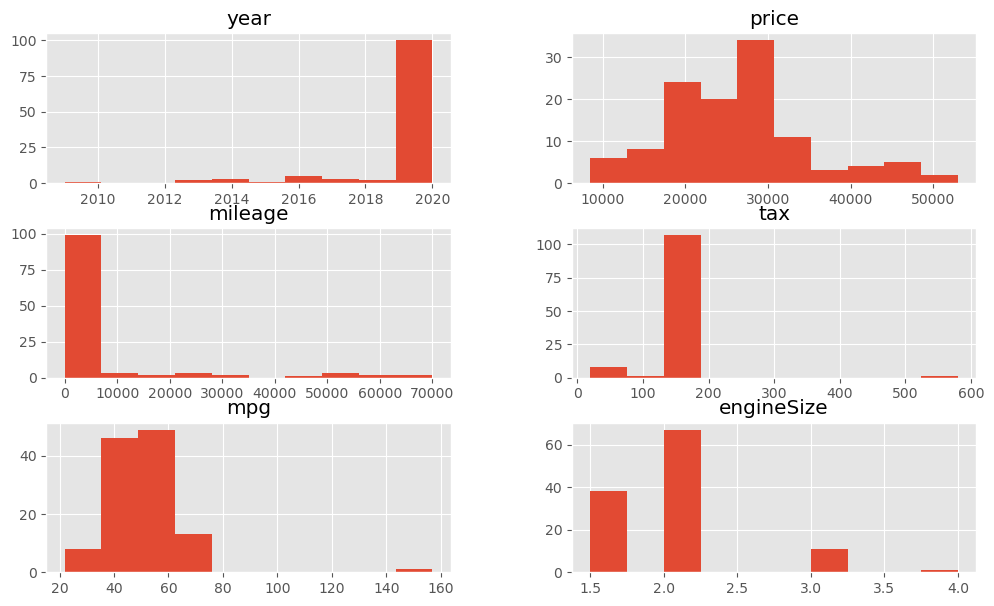

In [9]:
duplicate_rows = df[df.duplicated()]
duplicate_rows.hist(figsize=(12,7));

As we can see that the duplicated records don't seem to be outliers, but part of data we will keep them as removing them will impact regression. 
I looked at multiple posts to decide this. See [1](https://datascience.stackexchange.com/questions/90592/effect-of-removing-duplicates-on-random-forest-regression) [2](https://indicodata.ai/blog/should-we-remove-duplicates-ask-slater/) and [3](https://stats.stackexchange.com/questions/392216/removing-duplicates-before-train-test-split)

## What does target variable look like?

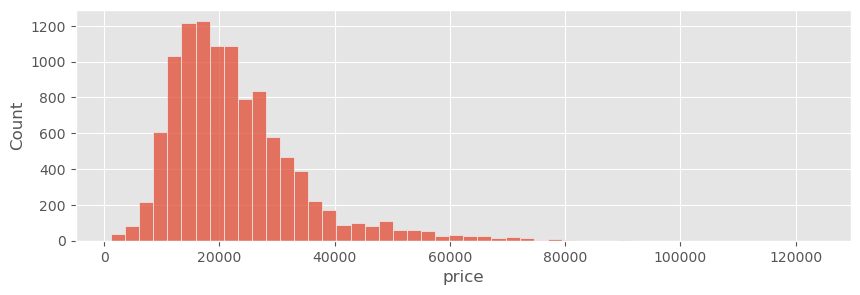

In [10]:
f, ax = plt.subplots(figsize=(10,3))
sns.histplot(df['price'], kde=False, bins=50)
plt.show()

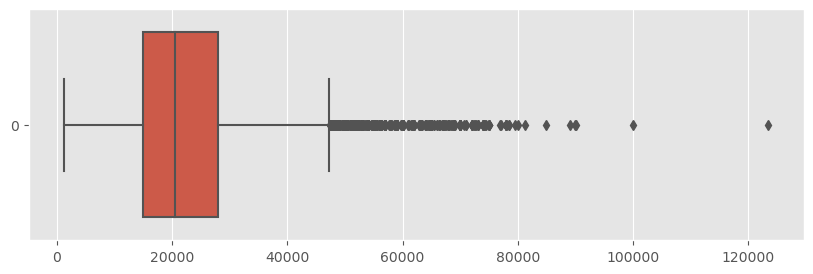

In [11]:
f, ax = plt.subplots(figsize=(10,3))
sns.boxplot(df['price'],orient="h")
plt.show()

In [12]:
print(f'mean: {df.price.mean():.1f}')
print(f'std: {df.price.std():.1f}')
print(f'Skewness: {df.price.skew():.5f}')
print(f'Kurtosis: {df.price.kurt():.5f}')

mean: 22733.4
std: 11415.5
Skewness: 1.58689
Kurtosis: 4.02149


There are some very expensive cars in out dataset and we will look into this later in the notebo0k

## Feature Engineering

In [13]:
# Construct new feature named age from year by subtracting year from 2022.
df['age'] = 2022 - df['year']

del df['year']

In [14]:
categorical_features = ['model', 'transmission', 'fuelType']
numerical_features = ['mileage', 'mpg', 'engineSize', 'age']

## Data range of numerical columns

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,10781.0,22733.408867,11415.528189,1200.0,14950.0,20462.0,27940.0,123456.0
mileage,10781.0,25496.986550,25143.192559,1.0,5529.0,18347.0,38206.0,214000.0
tax,10781.0,131.702068,61.510755,0.0,135.0,145.0,145.0,580.0
mpg,10781.0,56.399035,31.336958,5.5,45.6,53.3,62.8,470.8
engineSize,10781.0,2.167767,0.552054,0.0,2.0,2.0,2.0,6.6
age,10781.0,4.921065,2.349038,2.0,3.0,5.0,6.0,26.0


## Correlation Matrix

I will investigate the linear correlation of features, The code wasadopted from [here]()

In [16]:
''' Plot a Shifted Correlation Matrix '''
# Diagonal correlation is always unity & less relevant, shifted variant shows only relevant cases
def corrMat(data,id=False):
    
    corr_mat = data.corr().round(2)
    f, ax = plt.subplots(figsize=(4,2))
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    mask = mask[1:,:-1]
    corr = corr_mat.iloc[1:,:-1].copy()
    sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0, cmap='RdPu_r',square=False,lw=2,annot=True,cbar=False)
    #bottom, top = ax.get_ylim() 
    #ax.set_ylim(bottom + 0.5, top - 0.5) 
    for tick in ax.get_xticklabels():
        tick.set_rotation(65)
    ax.set_title('Shifted Linear Correlation Matrix')

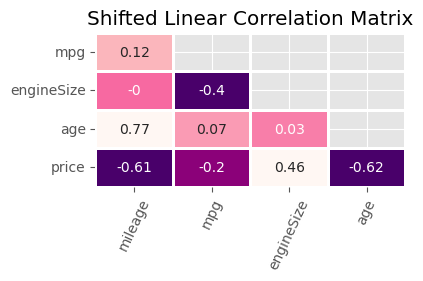

In [17]:
corrMat(df[['mileage', 'mpg', 'engineSize', 'age','price']],id=False)

In [18]:
#corr_data = df[['mileage', 'mpg', 'engineSize', 'age','price']].drop('price', axis=1).corrwith(df.price)

#f, ax = plt.subplots(figsize=(5,2))
#corr_data.plot(kind='bar', grid=True, title="Correlation with Price")#, figsize=(10, 2)
#for tick in ax.get_xticklabels():
#        tick.set_rotation(65);

**Observations:**

1. Price is negatively correlated with mileage and age which is logical as older cars will usually have higher mileage and command lower sale price compared to new cars with lower mileage
2. Engine Size has positive correlation with price - again it is logical that car with bigger engine size teand to be luxury of business cars hence they will be more expensive
3. MPG has weak negavtive correlation with price. Similar to previous point, luxury cars have bigger engines and lower MPG but they still have higher price becasue of their luxury aspect
4. Age and higly correlated with mileage, which is logical as older vehicles tend to have higher mileage

## Numerical feature analysis

In [19]:
# Function for exploratory data analysis of numerical features
def numerical_exploration(df):
    numerical_features = ['mileage', 'tax', 'mpg', 'engineSize','age']
    
    # Distribution plots
    for feature in numerical_features:
        plt.figure(figsize=(6, 2))
        sns.histplot(data=df, x=feature,bins=50)
        plt.title(f"Distribution of {feature}")
        plt.show()

In [20]:
#numerical_exploration(df)

## Visualize the relationship between the target variable and other numeric variables

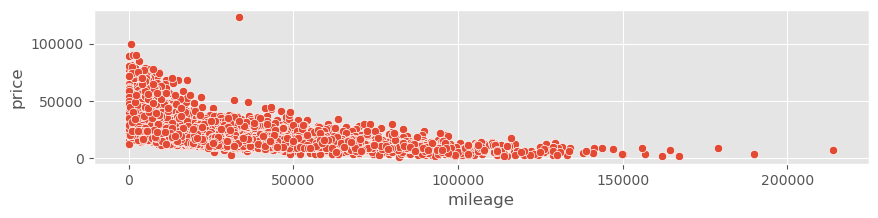

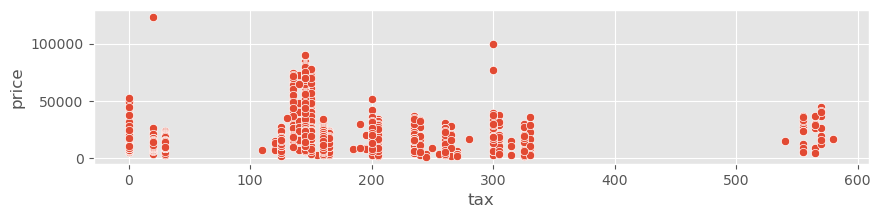

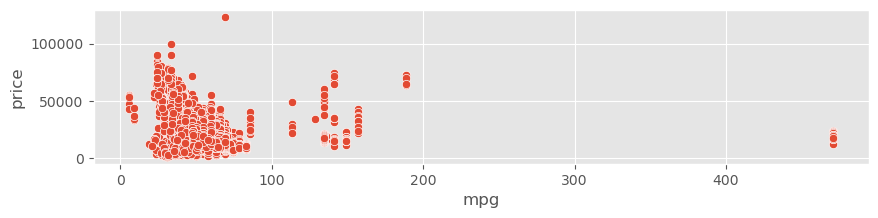

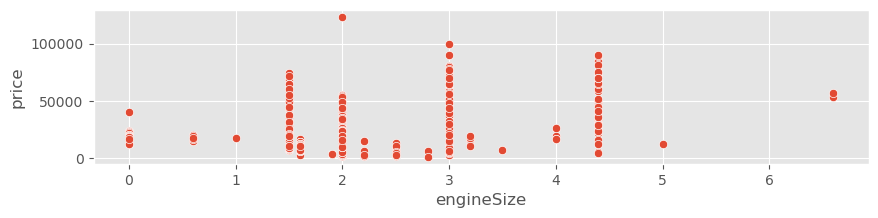

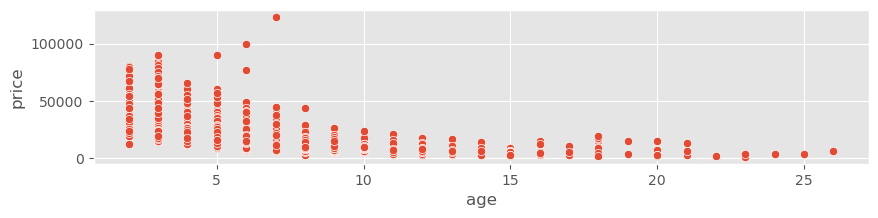

In [21]:
for column in df.columns:
    if df[column].dtype != 'object':
        if column != 'price':
            plt.figure(figsize=(10, 2))
            sns.scatterplot(x=df[column], y=df['price'])
            plt.show()

## Analysis of categorical features

In [22]:
def categorical_exploration(df, feature, size=(10, 4)):       
    # Boxplots
    #for feature in categorical_features:
    plt.figure(figsize=size)
    sns.boxplot(data=df, x=feature, y='price')
    plt.title(f"{feature} vs Price")
    plt.show()

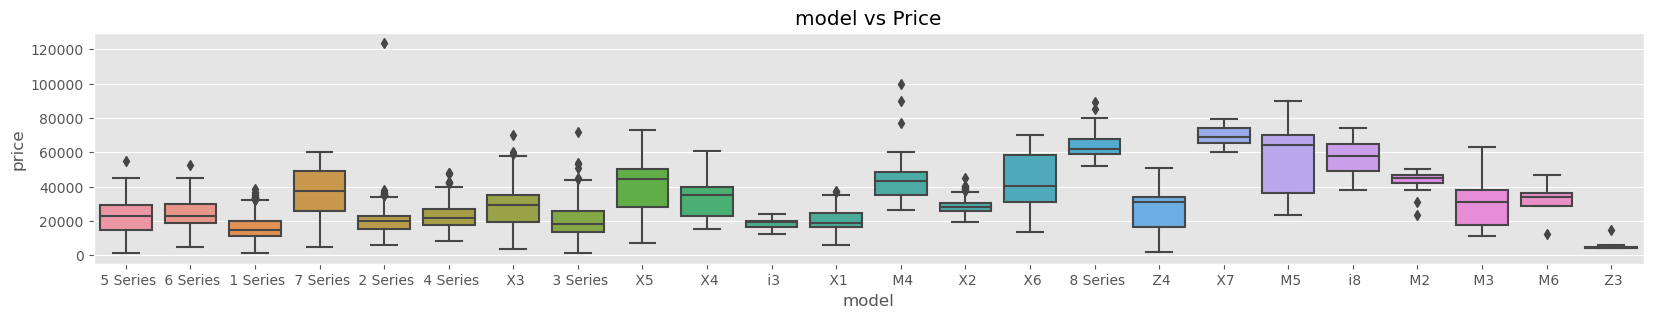

In [23]:
categorical_exploration(df, 'model',(20,3))

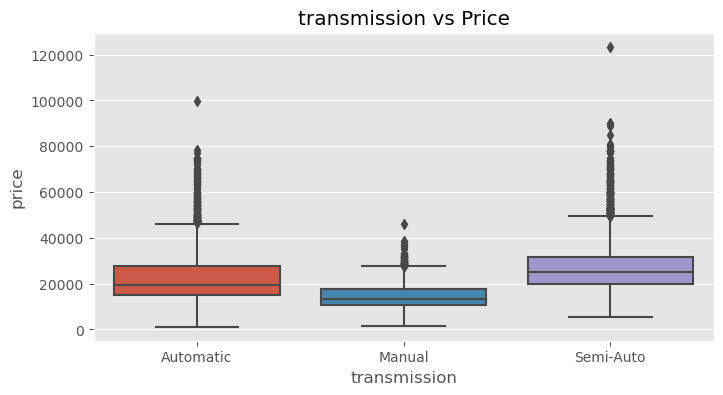

In [24]:
categorical_exploration(df, 'transmission',(8,4))

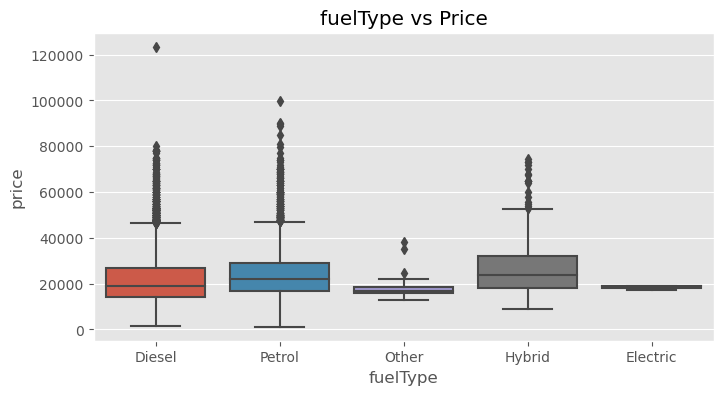

In [25]:
categorical_exploration(df, 'fuelType',(8,4))

In the chart above we can see that some fueltype vehicles are are very few in the dataset. So let's Merge the two leat common ones


In [26]:
df.fuelType.value_counts()

fuelType
Diesel      7027
Petrol      3417
Hybrid       298
Other         36
Electric       3
Name: count, dtype: int64

In [27]:
df['fuelType'] = df['fuelType'].replace({'Electric':'Other'})

In [28]:
df.fuelType.value_counts()

fuelType
Diesel    7027
Petrol    3417
Hybrid     298
Other       39
Name: count, dtype: int64

## Outliers analysis

Lets first look at the traget variable and use statistical figures to see possible outliers. 

In [29]:
# Function to detect outliers
def detect_outliers_zscore(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Detect outliers in the 'price' column
outliers = detect_outliers_zscore(df['price'])
print("{0} possible outliers with range {1} - {2}: ".format(len(outliers),np.min(outliers), np.max(outliers)))

201 possible outliers with range 56980 - 123456: 


In [30]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1, Q3 = np.percentile(sorted(data), [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    outliers = [x for x in data if x < lower_range or x > upper_range]
    return outliers

# Detect outliers in the 'price' column
outliers = detect_outliers_iqr(df['price'])
print("{0} possible outliers with range {1} - {2}: ".format(len(outliers),np.min(outliers), np.max(outliers)))

484 possible outliers with range 47440 - 123456: 


These are far too many values to be classed as outliers. Lets investigate by looking at some specific examples of possible outliers to determine if we need to transfer the values

### top 10 most expensive cars

In [31]:
df.sort_values(by='price', ascending=False).head(10)

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
3638,2 Series,123456,Semi-Auto,33419,Diesel,20,68.9,2.0,7
5362,M4,99950,Automatic,771,Petrol,300,33.2,3.0,6
2909,M4,89990,Semi-Auto,1336,Petrol,145,33.2,3.0,5
4776,M5,89900,Semi-Auto,2269,Petrol,145,24.1,4.4,3
1813,8 Series,88980,Semi-Auto,88,Petrol,145,24.4,4.4,3
721,8 Series,84898,Semi-Auto,3185,Petrol,145,24.4,4.4,3
5877,M5,81140,Semi-Auto,551,Petrol,145,24.1,4.4,3
6115,8 Series,79991,Semi-Auto,151,Diesel,145,26.7,3.0,2
7024,X7,79566,Semi-Auto,1000,Petrol,145,24.8,3.0,2
2602,X7,78490,Semi-Auto,4919,Diesel,145,31.4,3.0,2


In the top 10 most expensive car list all seem to be new luxury cars with low mileage except the ``2 Series`` at index ``3638`` and the price tag for this car seems to error.
Lets check this by looking stats for each car model

In [35]:
#df[df.model==' 2 Series'].price.plot.box()

In [36]:
# Group by 'model'
grouped = df.groupby('model')

# Calculate statistics
price_stats_df = grouped['price'].agg(['min', 'max', 'mean', 'median', stats.mode])
price_stats_df['mode_value'] = price_stats_df['mode'].apply(lambda x : x[0])
price_stats_df['mode_count'] = price_stats_df['mode'].apply(lambda x : x[1])

del price_stats_df['mode']
price_stats_df
#.reset_index()
#grouped['price'].agg(lambda x: stats.mode(x)[0][1])
#price_stats_df['mode_value'] = grouped['price'].agg(lambda x: stats.mode(x)[0][0])
#price_stats_df.style.background_gradient( cmap="RdYlGn")#, vmin=0, vmax=2.5)#subset=["2 Series"],

,min,max,mean,median,mode_value,mode_count
model,,,,,,
1 Series,1500,38555,15821.670391,14800.0,10999,14
2 Series,5895,123456,19539.371847,19980.0,20980,31
3 Series,1200,71990,19880.857962,18299.0,14500,15
4 Series,8500,48155,22498.418090,21975.0,21998,8
5 Series,1595,54845,22537.428030,22996.5,26350,16
6 Series,4995,52500,24354.370370,22854.0,20999,3
7 Series,4995,59995,36934.320755,37224.5,49990,3
8 Series,51980,88980,63997.794872,61898.0,55980,2
M2,23495,49999,43140.333333,44990.0,46000,2


Lets focus on ``2 series`` cars

In [37]:
df[df.model==' 2 Series'].sort_values(by='price', ascending=False).head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
3638,2 Series,123456,Semi-Auto,33419,Diesel,20,68.9,2.0,7
9710,2 Series,37989,Automatic,3890,Petrol,145,36.2,2.0,2
5768,2 Series,36840,Semi-Auto,2422,Petrol,145,36.2,2.0,2
5553,2 Series,36771,Semi-Auto,485,Petrol,145,36.2,2.0,2
427,2 Series,36000,Semi-Auto,5550,Petrol,145,36.2,2.0,2


Looking at the tables above and the price ``123456`` it seems that it is data input error and hence we should just remove it from out data

In [38]:
# get index of car to remove
idx_to_remove = df[df.price==123456].index
# drop the car
df.drop(idx_to_remove, inplace= True)